<a href="https://colab.research.google.com/github/Droid008/PyTorch-framework-for-the-development-of-artificial-neural-networks/blob/Lesson-%237/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### 1. Генерация точек графика

Как было сказано ранее, GAN обучается воспроизводить реальные данные.
Поэтому Вам предлагается обучить генератор создавать точки, которые будут
лежать на графике функции:

$$y=\frac{sin{x}}{x} −\frac{x}{10}$$

При выполнении данного задания структура GAN остается той же, но Вам нужно:
 - Сгенерировать настоящие данные
 - Изменить архитектуру дискриминатора и генератора
 - Без графиков домашку не принимаю

In [2]:
def my_func(x):
    return (torch.sin(x)/x) - (x/10)

In [3]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 30 * torch.rand(train_data_length) - 15
train_data[:, 1] = my_func(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

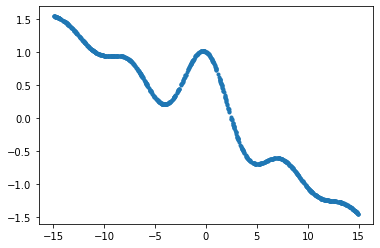

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [9]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 50 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.09207610040903091
Epoch: 0 Loss G.: 2.275897979736328
Epoch: 50 Loss D.: 0.6326843500137329
Epoch: 50 Loss G.: 0.875059187412262
Epoch: 100 Loss D.: 0.6386690139770508
Epoch: 100 Loss G.: 1.0841065645217896
Epoch: 150 Loss D.: 0.6926447153091431
Epoch: 150 Loss G.: 0.7551173567771912
Epoch: 200 Loss D.: 0.6227330565452576
Epoch: 200 Loss G.: 0.7523910403251648
Epoch: 250 Loss D.: 0.5867735743522644
Epoch: 250 Loss G.: 0.8356497287750244
Epoch: 300 Loss D.: 0.5699099898338318
Epoch: 300 Loss G.: 0.7776724696159363
Epoch: 350 Loss D.: 0.6420992612838745
Epoch: 350 Loss G.: 0.9833740592002869
Epoch: 400 Loss D.: 0.6097645163536072
Epoch: 400 Loss G.: 0.8627021312713623
Epoch: 450 Loss D.: 0.5758951306343079
Epoch: 450 Loss G.: 1.3914717435836792


In [12]:
latent_space_samples = torch.randn(300, 2)
generated_samples = generator(latent_space_samples)

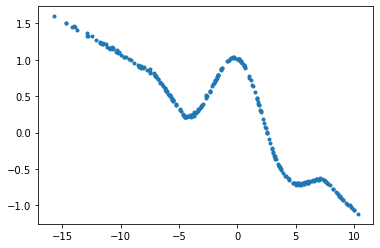

In [13]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")